In [1]:
import os


if 'tfg' not in os.listdir():
    os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tfg.alphaZero import AlphaZero
from tfg.alphaZeroAdapters import TicTacToeAdapter
from tfg.util import enable_gpu
from game.tictactoe import TicTacToe

In [3]:
enable_gpu()

game = TicTacToe()
adapter = TicTacToeAdapter()
az = AlphaZero(game, adapter)
az.load('models/TicTacToe.h5')
model = az.neural_network.model

In [4]:
def plot_token(i, j, token, color=None, linewidth=4):
    if color is None:
        color = 'k'
    if linewidth is None:
        linewidth = 4
    
    if token == WHITE:
        x = [j + .2, j + .8]
        y = [2 - i + .2, 2 - i + .8]
        plt.plot(x, y, linewidth=linewidth, c=color)
        plt.plot(x, y[::-1], linewidth=linewidth, c=color)
    elif token == BLACK:
        circle = plt.Circle((j + .5, 2 - i + .5), .35, color=color, linewidth=linewidth, fill=False)
        plt.gca().add_patch(circle)

def plot_board(board, value=None, probabilities=None, alpha=1, cmap='winter', color=None, linewidth=None):
    fig = plt.gcf()
    
    if probabilities is not None:
        probs = probabilities.reshape(3, 3)
        plt.imshow(probs, cmap=cmap, extent=[0, 3, 0, 3], alpha=alpha)
        plt.clim(0, 1)
        plt.colorbar()
    
    plt.gca().set_axis_off()
    
    for i in (1, 2):
        plt.plot([i, i], [0, 3], 'k', linewidth=4)
        plt.plot([0, 3], [i, i], 'k', linewidth=4)
        
    for i in range(3):
        for j in range(3):
            plot_token(i, j, board[i, j], color, linewidth)
            if probabilities is not None:
                plt.text(j + .5, 2 - i + .5, f'{probs[i, j]:.3f}', fontsize=14,
                         color='w', weight='bold', ha='center', va='center')
    
    if value is not None:
        ax = fig.axes[0]
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height + .043])
        ax = fig.add_axes([pos.x0 + .015, pos.y0 - .07, .488, .036])
        cmap = mpl.colors.ListedColormap(['w', 'k'])
        bounds = [-1, value, 1]
        ticks = [-1, 1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        mpl.colorbar.ColorbarBase(
            ax, cmap=cmap,
            norm=norm,
            boundaries=bounds,
            ticks=ticks,
            spacing='proportional',
            orientation='horizontal'
        )
        ax.plot([0, 0], [-1, 1], 'gray')
        ha, c = ('left', 'w') if value < 0 else ('right', 'k')
        ax.text(value, -.22, f'{value:.3f}', ha=ha, va='center', c=c, fontsize=10, weight='bold')
    
    return fig

## Evaluations of different boards

In [5]:
from tfg.games import WHITE, BLACK


# Make arrays more visual
X = WHITE
O = BLACK
_ = 0


boards = np.array([
    [[_, _, _],
     [_, _, _],
     [_, _, _]],
    
    [[X, O, _],
     [_, _, _],
     [_, _, _]],
    
    [[X, O, O],
     [_, X, _],
     [_, _, _]],
    
    [[X, O, O],
     [_, X, _],
     [_, _, X]],
    
    [[X, X, O],
     [_, O, X],
     [_, _, _]],
    
    [[O, _, O],
     [X, O, X],
     [_, _, X]],
    
    [[X, O, X],
     [X, O, O],
     [_, X, _]],
    
    [[O, _, _],
     [_, X, _],
     [_, _, X]]
])

turns = [WHITE if board.sum() == 0 else BLACK for board in boards]

In [6]:
nn_input = np.stack([adapter.to_input(board, to_play)
                     for board, to_play in zip(boards, turns)])

In [7]:
values, probabilities = model(nn_input)

In [8]:
values = values.numpy().reshape(-1) * np.array(turns)

In [9]:
probabilities = probabilities.numpy()

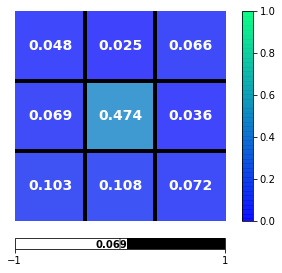

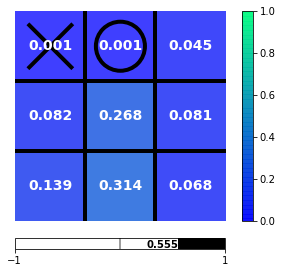

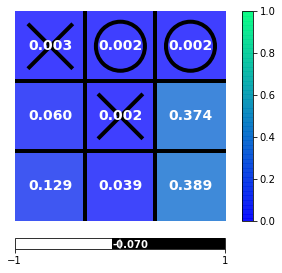

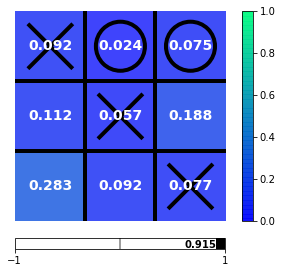

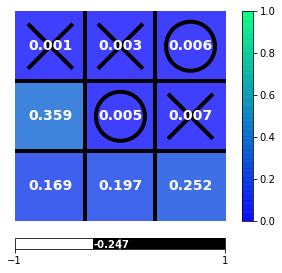

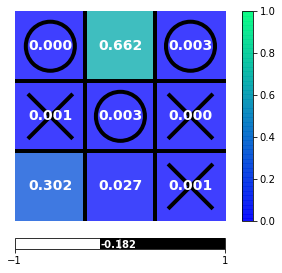

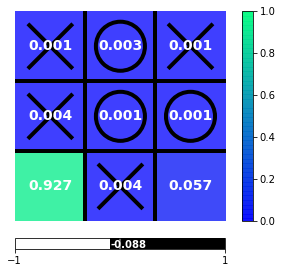

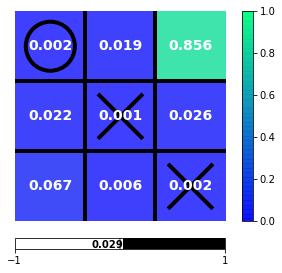

In [10]:
for i, (board, value, probs) in enumerate(zip(boards, values, probabilities)):
    fig = plot_board(board, value, probs, alpha=.75)
    plt.gcf().subplots_adjust(bottom=.15)
    plt.show()

## Favorite moves during training

Not trained yet


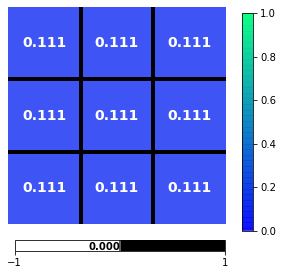

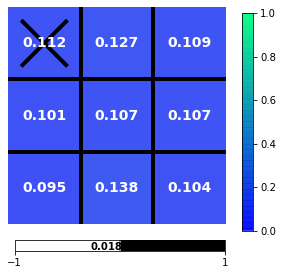

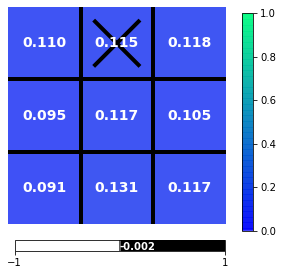

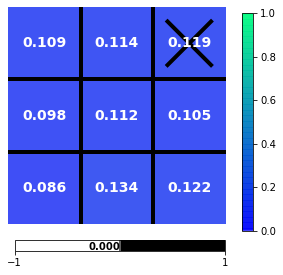

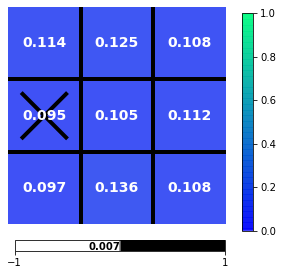

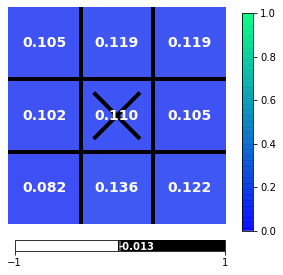

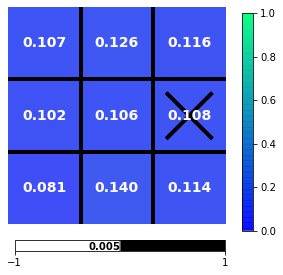

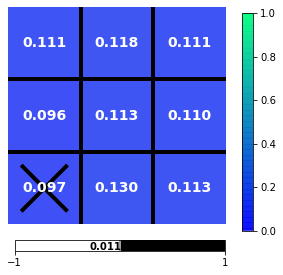

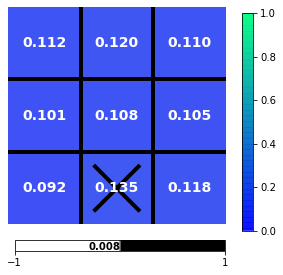

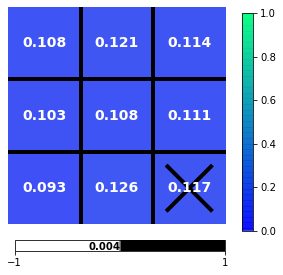

checkpoint1.h5


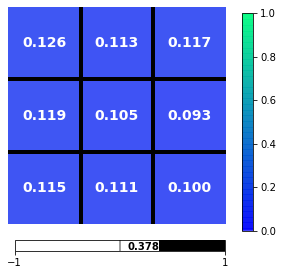

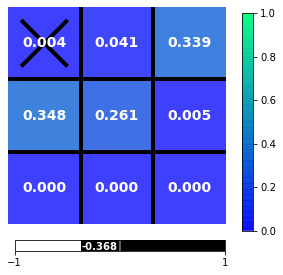

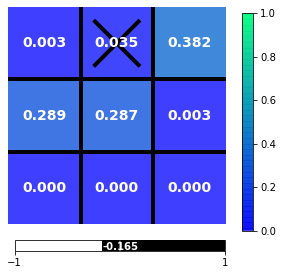

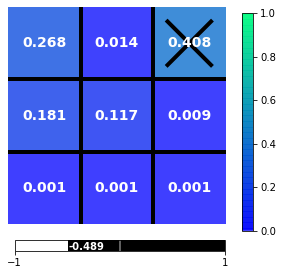

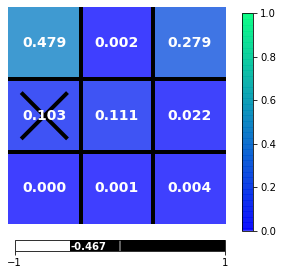

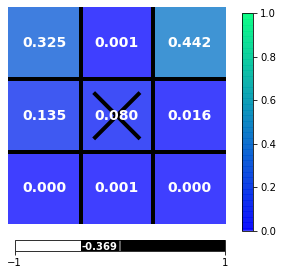

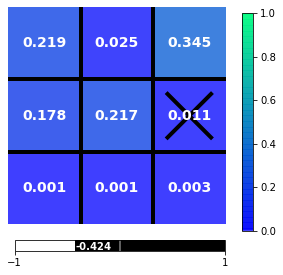

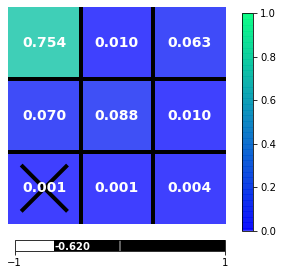

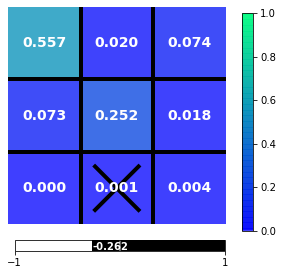

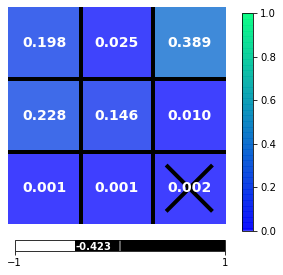

checkpoint3.h5


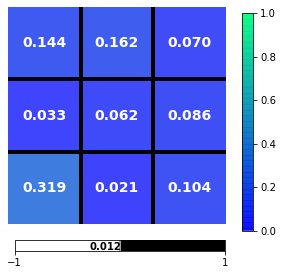

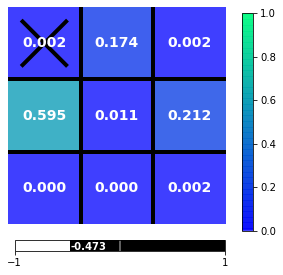

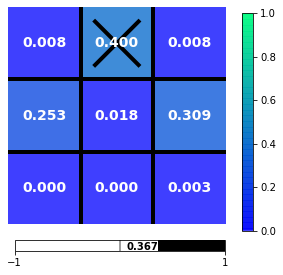

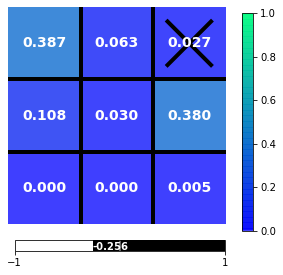

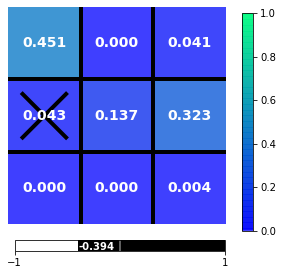

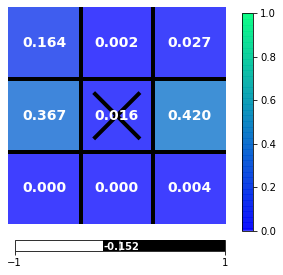

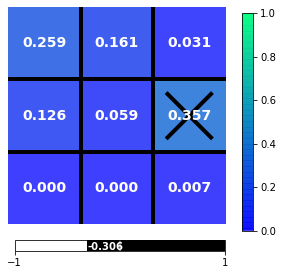

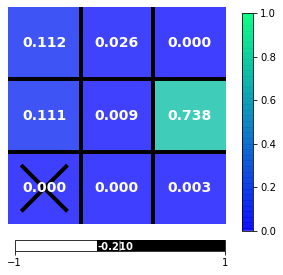

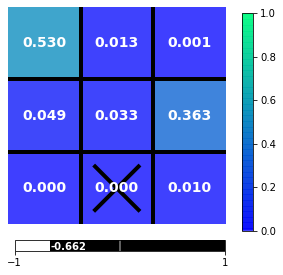

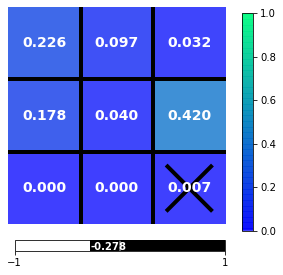

checkpoint5.h5


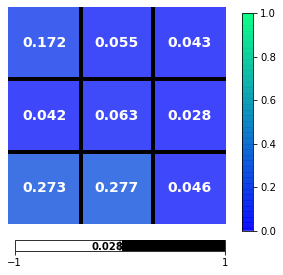

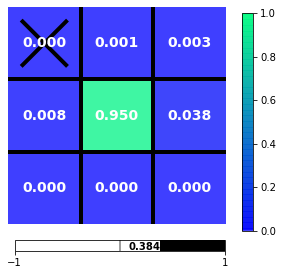

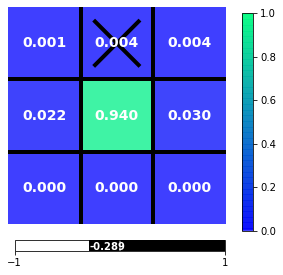

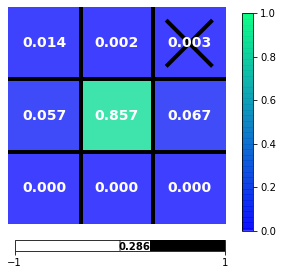

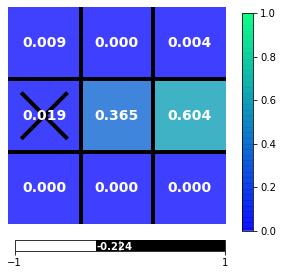

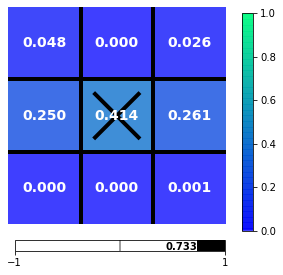

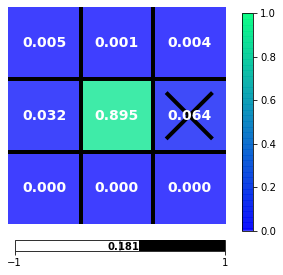

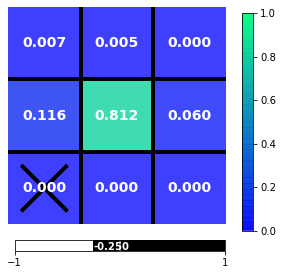

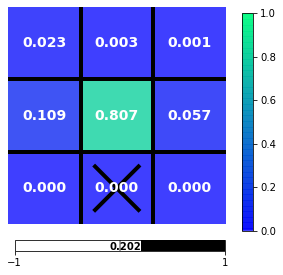

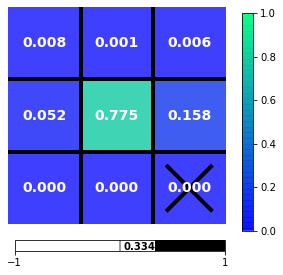

checkpoint7.h5


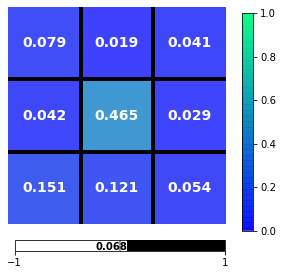

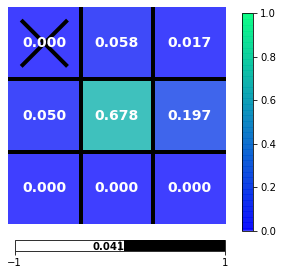

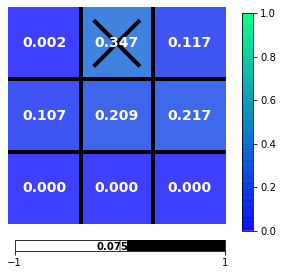

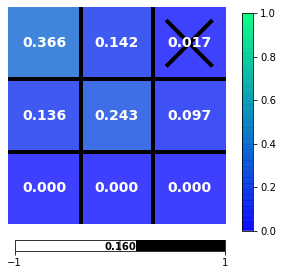

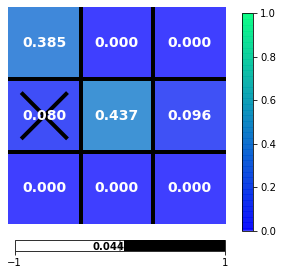

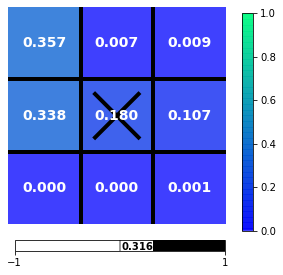

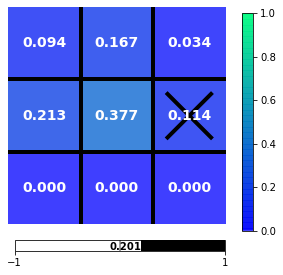

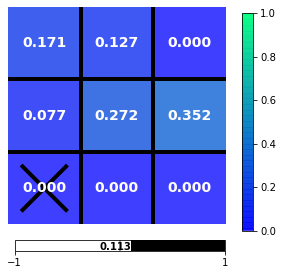

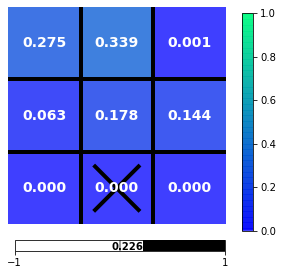

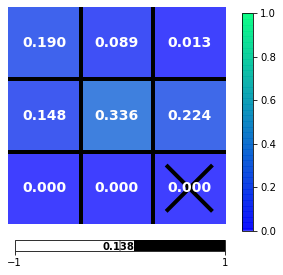

In [11]:
DIR = 'models/checkpoints/tictactoe'

az = AlphaZero(game, adapter)
k = 0

for filename in [None] + os.listdir(DIR):
    if filename is not None:
        k += 1
        if k % 2 == 0:
            continue
        az.load(os.path.join(DIR, filename))
        print(filename)
    else:
        print("Not trained yet")
    
    model = az.neural_network.model
    board = np.zeros((1, 3, 3, 3))
    v, p = model(board)
    v = v.numpy()[0, 0]
    p = p.numpy()[0]
    plot_board(board[0, 0, ...], v, p, alpha=.75)
    plt.show()
    
    board[0, 2, ...] = 1
    for i in range(3):
        for j in range(3):
            board[0, 0, ...] = 0
            board[0, 0, i, j] = 1
            v, p = model(board)
            v = v.numpy()[0, 0]
            p = p.numpy()[0]
            v *= -1
            plot_board(board[0, 0, ...], v, p, alpha=.75)
            plt.show()